In [181]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import check_X_y
from sklearn.utils import check_random_state
from sklearn.utils import shuffle
import theano
import theano.tensor as tt
from theano import shared
from time import time
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams 

In [182]:
from sklearn.datasets import fetch_mldata
from sklearn.utils import check_array
from sklearn.cross_validation import train_test_split


def load_data(dtype=np.float32, order='C'):
    """Load the data, then cache and memmap the train/test split"""
    print("Loading dataset...")
    data = fetch_mldata('MNIST original')
    X = check_array(data['data'], dtype=dtype, order=order)
    y = data["target"].astype(np.int32)
    # Scale the features to [0, 1]
    X = X / 255
    ## Create train-test split (as [Joachims, 2006])
    print("Creating train-test split...")
    n_train = 60000
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]
    return X_train, X_test, y_train, y_test

X_dev, X_test, y_dev, y_test = load_data()

# Create a small training set for faster experiments
X_train, X_val, y_train, y_val = train_test_split(
    X_dev, y_dev, test_size=int(1e3), random_state=0)

Loading dataset...
Creating train-test split...


## Various neural networks utilities

Mostly taken from Alec Radford and Kyle Kastner's gists:

- https://gist.github.com/Newmu/a56d5446416f5ad2bbac
- https://gist.github.com/kastnerkyle/f3f67424adda343fef40

In [183]:
def sharedf32(X, dtype=np.float32, name=None):
    return theano.shared(np.asarray(X, dtype=dtype), name=name)


def softmax(x):
    return tt.nnet.softmax(x)


def relu(x):
    return (x + abs(x)) / 2.0


def tanh(x):
    return tt.tanh(x)


def sigmoid(x):
    return tt.nnet.sigmoid(x)


def linear(x):
    return x


def iter_data(*data, **kwargs):
    batch_size = kwargs.get('batch_size', 128)
    batches, remainder = divmod(len(data[0]), batch_size)
    if remainder != 0:
        batches += 1
    for b in range(batches):
        start = b * batch_size
        end = (b + 1) * batch_size
        if len(data) == 1:
            yield data[0][start:end]
        else:
            yield tuple([d[start:end] for d in data])

## Optimizers 

In [184]:
# XXX: do not use this. it probably has a bug

class Adam(object):
    """no bias init correction and no b1 decay"""
    
    def __init__(self, learning_rate=0.01, grad_momentum=0.1,
                 sq_grad_momentum=0.001, eps=1e-8):
        self.learning_rate = learning_rate
        self.grad_momentum = grad_momentum
        self.sq_grad_momentum = sq_grad_momentum
        self.eps = eps

    def make_updates(self, params, cost):
        b1 = np.array(self.grad_momentum, dtype=np.float32)
        b2 = np.array(self.sq_grad_momentum, dtype=np.float32)
        lr = np.array(self.learning_rate, dtype=np.float32)
        eps = np.array(self.eps, dtype=np.float32)
        one = np.array(1, dtype=np.float32)
        updates = []
        grads = tt.grad(cost, params)
        for p, g in zip(params, grads):
            m = sharedf32(p.get_value() * 0., name='m')
            v = sharedf32(p.get_value() * 0., name='v')
            m_t = (b1 * g) + ((one - b1) * m)
            v_t = (b2 * tt.sqr(g)) + ((one - b2) * v)
            g_t = m_t / (tt.sqrt(v_t) + eps)
            p_t = p - lr * g_t
            updates.append((m, m_t))
            updates.append((v, v_t))
            updates.append((p, p_t))
        return updates
    

class MomentumSGD(object):
    
    monitor = None
    
    def __init__(self, learning_rate_init=0.1, max_adaptation_count=3,
                 learning_rate_scale=0.2, momentum=0.9, rescale=0.5):
        self.learning_rate_init = learning_rate_init
        self.max_adaptation_count = max_adaptation_count
        self.learning_rate_scale = learning_rate_scale
        self.momentum = momentum
        self.rescale = rescale
        
    def on_stalled_convergence(self):
        if self.adaptation_count > self.max_adaptation_count:
            # Optimizer thinks model has converged
            return False
        
        scale = np.array(self.learning_rate_scale, dtype=np.float32)
        
        # Rescale the learning rate
        old_lr = self.learning_rate.get_value()
        new_lr = old_lr * scale
        self.learning_rate.set_value(new_lr)
        self.adaptation_count += 1
        print("Updated learning rate from %f to %f" % (old_lr, new_lr))

    def make_updates(self, params, cost):
        self.adaptation_count = 0
        self.learning_rate = sharedf32(self.learning_rate_init,
                                       name='learning_rate')
        momentum = np.array(self.momentum, dtype=np.float32)

        updates = []
        grads = tt.grad(cost, params)
        for p, g in zip(params, grads):
            if self.momentum > 0:
                v = sharedf32(p.get_value() * 0., name='v')
                v_t = momentum * v - self.learning_rate * g
                p_t = p + v_t
                updates.append((v, v_t))
            else:
                # traditional SGD
                p_t = p - self.learning_rate * g
            updates.append((p, p_t))
        return updates

    
class NesterovMomentumSGD(MomentumSGD):

    def make_updates(self, params, cost):
        self.adaptation_count = 0
        self.learning_rate = sharedf32(self.learning_rate_init,
                                       name='learning_rate')
        momentum = np.array(self.momentum, dtype=np.float32)
        updates = []
        grads = tt.grad(cost, params)
#         grad_norm = tt.sqrt(sum(map(lambda x: tt.sqr(x).sum(), grads)))
#         param_norm = tt.sqrt(sum(map(lambda x: tt.sqr(x).sum(), params)))
#         rescale = np.array(self.rescale, dtype=np.float32)
#         not_finite = tt.or_(tt.isnan(grad_norm), tt.isinf(grad_norm))
#         scaling_num = rescale
#         scaling_den = tt.maximum(rescale, grad_norm)
    
        tenth = np.array(0.1, dtype=np.float32)
        for p, g in zip(params, grads):
#             g = tt.switch(not_finite, tenth * p, g * (scaling_num / scaling_den))
            v = sharedf32(p.get_value() * 0., name='v')
            v_t = momentum * v - self.learning_rate * g
            p_t = p + momentum * v_t - self.learning_rate * g
            updates.append((v, v_t))
            updates.append((p, p_t))
        return updates
#         return grad_norm, param_norm, updates

## Orchestration

In [185]:
class EarlyStoppingMonitor(object):
    def __init__(self, X_train, y_train, X_val=None, y_val=None, patience=5,
                 data_log_filename=None, subsample=int(5e3), tol=1e-5, random_state=None):

        X_train, y_train = check_X_y(X_train, y_train, dtype=np.float32)
        y_train = y_train.astype(np.int32, copy=False)
        self.label_binarizer_ = lb = LabelBinarizer().fit(y_train)

        if subsample is not None and subsample < X_train.shape[0]:
            X_train, y_train = shuffle(X_train, y_train, random_state=random_state)
            X_train = X_train[:subsample]
            y_train = y_train[:subsample]
        self.X_train = X_train
        self.y_train = y_train
        self.Y_train = lb.transform(y_train).astype(np.float32)
        self.tol = tol

        if X_val is not None:
            X_val, y_val = check_X_y(X_val, y_val, dtype=np.float32)
            if subsample is not None and subsample < X_val.shape[0]:
                X_val, y_val = shuffle(X_val, y_val,
                                       random_state=random_state)
                X_val = X_val[:subsample]
                y_val = y_val[:subsample]
            self.Y_val = lb.transform(y_val).astype(np.float32)
        self.X_val = X_val
        self.y_val = y_val

        self.data_log_filename = data_log_filename
        self.patience_reset = patience
        self.reset()
    
    def reset(self):
        self.best_cost = np.inf
        self.patience = self.patience_reset
        self.timestamp = time()
    
    def accuracy(self, y_true, output):
        indices = output.argmax(axis=1)
        return np.mean(self.label_binarizer_.classes_[indices] == y_true)
        
    def monitor(self, model, context):
        duration = time() - self.timestamp
        epoch = context.get('epoch')
        optimizer = context.get('optimizer')
        
        training_out, training_cost = model._forward_and_cost(
            self.X_train, self.y_train)
        training_acc = self.accuracy(self.y_train, training_out)
        if self.X_val is not None:
            validation_out, validation_cost = model._forward_and_cost(
                self.X_val, self.y_val)
            validation_acc =  self.accuracy(self.y_val, validation_out)
            current_cost = validation_cost      
        else:
            validation_cost = None
            validation_acc = None
            current_cost = training_cost

        msg = "Epoch #%03d, training cost: %0.6f, acc: %0.4f" % (
            epoch, training_cost, training_acc)
        
        if self.X_val is not None:
            msg += ", validation cost: %0.6f, acc: %0.4f" % (
                validation_cost, validation_acc)
        msg += ", duration: %0.3fs " % duration
        print(msg)

        # Patience-based stopping condition
        if current_cost < self.best_cost - self.tol:
            self.patience = self.patience_reset
            self.best_cost = current_cost
        elif (hasattr(optimizer, 'on_stalled_convergence')
              and not optimizer.on_stalled_convergence()):
            # Optimizer has already had enough opportunities to adapt the
            # learning rate in the past. We can start loosing patience.
            self.patience -= 1
        else:
            # The optimizer does not use validation set convergence info,
            # we can loose patience without notifying it.
            self.patience -= 1

        self.timestamp = time()
        return self.patience > 0

In [186]:
def shuffle_columns(X, copy=True, random_state=None):
    rng = check_random_state(random_state)
    if copy:
        X = X.copy()
    for i in range(X.shape[1]):
        rng.shuffle(X[:, i])
    return X

In [248]:
class MLPClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, hidden=(100, 100), activation='relu', init_gain='auto',
                 batch_size=128, optimizer=None,
                 weight_decay=int(1e-5), warm_start=False,
                 contrast_ratio=.5,
                 max_iter=1000, random_state=None):
        self.hidden = hidden
        self.activation = activation
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.weight_decay = weight_decay
        self.init_gain = init_gain
        self.warm_start = warm_start
        self.random_state = random_state
        self.max_iter = max_iter
        self.contrast_ratio = contrast_ratio
        
    def _init_parameters(self, n_features, n_outputs):
        rng = check_random_state(self.random_state)
        input_dims = (n_features,) + self.hidden
        output_dims = self.hidden + (n_outputs,)

        if self.init_gain == 'auto':
            g = np.sqrt(2) if self.activation == 'relu' else 1.
        else:
            g = self.init_gain
        
        self.weights_ = []
        self.biases_ = []
        for l, (in_dim, out_dim) in enumerate(zip(input_dims, output_dims)):
            std = g * np.sqrt(2 / (in_dim + out_dim))
            W = sharedf32(rng.normal(size=(in_dim, out_dim), scale=std),
                          name='W_%d' % l)
            self.weights_.append(W)
            b = sharedf32(np.zeros(out_dim), name='b_%d' % l)
            self.biases_.append(b)
        
    def _make_functions(self, contrast_ratio):
        x = tt.fmatrix(name='x')
        y = tt.ivector(name='y')
        contrast_activations = tt.fmatrix(name='contrast_activations')

        # Define the computation graph of the model
        if self.activation == 'relu':
            sigma = relu
        elif self.activation == 'tanh':
            sigma = tanh
        elif self.activation == 'linear':
            sigma = linear
        else:
            raise ValueError('Unsupported activation: %s' % self.activation)
        
        transfer_funcs = [sigma] * (len(self.weights_) - 1) + [softmax]
        n_layers = len(transfer_funcs)
        activations = []
        activation = x
        for l, w, b, s in zip(range(n_layers), self.weights_,
                              self.biases_, transfer_funcs):
            activation = s(tt.dot(activation, w) + b)
            activation.name = 'activations_%d' % l
            activations.append(activation)
        
        output = activation
        classification_cost = tt.nnet.categorical_crossentropy(output, y).mean()
        contrast_cost = (tt.dot(activations[-2], contrast_activations.T) ** 2).mean()
        
        if contrast_ratio > 0 and contrast_ratio < 1:
            cost = (1 - self.contrast_ratio) * classification_cost
            cost += self.contrast_ratio * contrast_cost
        elif contrast_ratio == 1:
            cost = contrast_cost
        else:
            cost = classification_cost
        
        weight_decay = np.array(self.weight_decay, dtype=np.float32)
        if self.weight_decay > 0:
            for w in self.weights_:
                cost += weight_decay * tt.sqr(w).sum()
        
        # Use the optimizer to compute the parameter updates based
        # on the gradient of the cost function
        opt = self.optimizer
        if opt is None:
            opt = Adam()

        parameters = []
        parameters += self.weights_
        parameters += self.biases_
#         grad_norm, param_norm, fit_updates = opt.make_updates(parameters, cost)
        fit_updates = opt.make_updates(parameters, cost)
        
        # Compile the functions them-selves
        f = theano.function
        if contrast_ratio > 0 and contrast_ratio < 1:
            self._fit = f([x, y, contrast_activations],
              cost, updates=fit_updates, name='_fit')
        elif contrast_ratio == 0:
            self._fit = f([x, y], cost, updates=fit_updates, name='_fit')
        else:
            self._fit = f([x, contrast_activations],
                          cost, updates=fit_updates, name='_fit')

#         self._fit = f([x, y], (cost, grad_norm, param_norm),
#                       updates=fit_updates, name='_fit')
        self._forward_and_cost = f([x, y], (output, classification_cost), name="_forward_and_cost")
        self._forward = f([x], output, name="_forward")
        inputs = [x] + activations[:-1]
        self._forward_funcs = []
        for i, input_ in enumerate(inputs):
            self._forward_funcs.append(f([input_], activations[i:],
                                         name="_forward_activations_%d" % i))
        return opt
    
    def forward_shuffle(self, X, layer_idx=0, random_state=None):
        if random_state is None:
            random_state = self.random_state
        if layer_idx == -1:
            all_activations = []
            activations = X.copy()
        else:
            all_activations = self._forward_funcs[0](X)
            activations = all_activations[layer_idx]
        shuffle_activations = shuffle_columns(activations, random_state=random_state)
        after_shuffle_activations = self._forward_funcs[layer_idx + 1](shuffle_activations)
        return all_activations[:layer_idx + 1] + [shuffle_activations] + after_shuffle_activations

    def fit(self, X, y=None, monitor=None):
        X, y = check_X_y(X, y, dtype=np.float32)
        y = y.astype(np.int32, copy=False)
        self.label_binarizer_ = lb = LabelBinarizer()
        Y = lb.fit_transform(y).astype(np.float32)
        n_samples, n_features = X.shape
        _, n_outputs = Y.shape
        if not self.warm_start or not hasattr(self, 'weights_') :
            self._init_parameters(n_features, n_outputs)

        contrast_ratio = self.contrast_ratio if y is not None else 1.
        optimizer = self._make_functions(contrast_ratio)
        self.training_costs_ = []
        if monitor is not None:
            monitor.reset()

        try:
            for epoch in range(self.max_iter):
                if monitor is not None and not monitor.monitor(self, locals()):
                    break
                for X_batch, y_batch in iter_data(X, y, batch_size=self.batch_size):
#                     cost, grad_norm, param_norm = self._fit(X_batch, y_batch)
                    if self.contrast_ratio > 0:
                        layer_idx = np.random.randint(-1, 2)
                        contrast_activations = self.forward_shuffle(X_batch, layer_idx=layer_idx)[-2]
                        cost = self._fit(X_batch, y_batch, contrast_activations)
                    else:
                        cost = self._fit(X_batch, y_batch)
#                     print(grad_norm, param_norm)
                    self.training_costs_.append(cost)
        except KeyboardInterrupt:
            print("Interruped by user")

        return self
    
    def predict_proba(self, X):
        X = check_array(X, dtype=np.float32)
        return self._forward(X)

    def predict(self, X):
        indices = self.predict_proba(X).argmax(axis=1)
        return indices
#         return self.label_binarizer_.classes_[indices]

In [260]:
%%time
monitor = EarlyStoppingMonitor(X_train, y_train, X_val=X_val, y_val=y_val,
                               patience=10, random_state=0)
train_only_monitor = EarlyStoppingMonitor(X_train, y_train, random_state=0)

optimizer = NesterovMomentumSGD(learning_rate_init=.1, learning_rate_scale=0.5, momentum=0.9)
mlp = MLPClassifier(hidden=(1000, 1000), batch_size=128, weight_decay=1e-4,
                    contrast_ratio=0.005,
                    init_gain='auto', optimizer=optimizer, max_iter=100, random_state=0)
mlp.fit(X_train, y_train, monitor=monitor)

Epoch #000, training cost: 2.469210, acc: 0.0854, validation cost: 2.489720, acc: 0.0780, duration: 0.000s 
Epoch #001, training cost: 0.111276, acc: 0.9660, validation cost: 0.142365, acc: 0.9580, duration: 26.942s 
Epoch #002, training cost: 0.071616, acc: 0.9804, validation cost: 0.091475, acc: 0.9730, duration: 26.623s 
Epoch #003, training cost: 0.048391, acc: 0.9856, validation cost: 0.074663, acc: 0.9790, duration: 26.828s 
Interruped by user
CPU times: user 3min 36s, sys: 4.89 s, total: 3min 41s
Wall time: 1min 48s


In [261]:
test_score = mlp.score(X_test, y_test)
print(test_score, 1 - test_score)

0.9753 0.0247


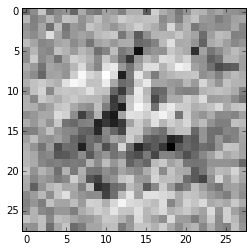

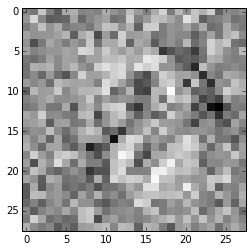

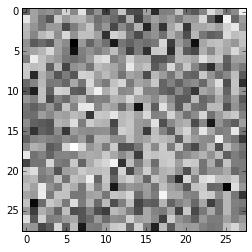

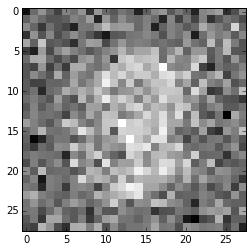

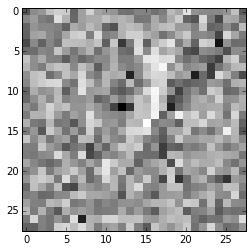

In [262]:
for i in range(5):
    plt.figure()
    plt.imshow(mlp.weights_[0].get_value()[:, i].reshape(28, 28), cmap=plt.cm.Greys,
           interpolation='nearest');

In [263]:
%%time
[a.shape for a in mlp.forward_shuffle(X_train[:10], layer_idx=1)]

CPU times: user 7.74 ms, sys: 206 µs, total: 7.94 ms
Wall time: 5.24 ms


[(10, 1000), (10, 1000), (10, 1000), (10, 10)]

In [264]:
from sklearn.metrics.pairwise import cosine_similarity

sims = cosine_similarity(out[:100], out_shuffled_activations[:100]).ravel()
inner_sims = cosine_similarity(out[:100]).ravel()

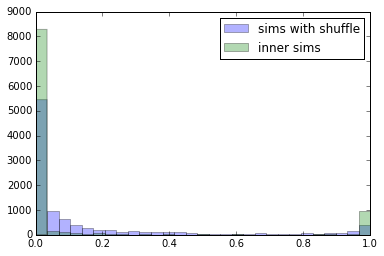

In [85]:
bins = np.linspace(0, 1, 30)
alpha = 0.3

plt.hist(sims, bins=bins, alpha=alpha, label='sims with shuffle')
plt.hist(inner_sims, bins=bins, alpha=alpha, label='inner sims')
plt.legend(loc='best');

In [90]:
np.mean(sims > 0.01)

0.63160000000000005

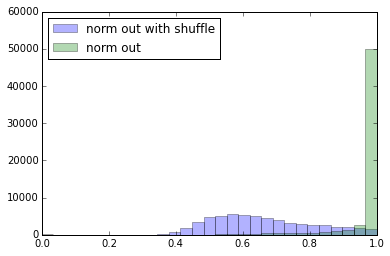

In [91]:
bins = np.linspace(0, 1, 30)
alpha = 0.3

plt.hist(np.linalg.norm(out_shuffled_activations, axis=1), bins=bins, alpha=alpha, label='norm out with shuffle')
plt.hist(np.linalg.norm(out, axis=1), bins=bins, alpha=alpha, label='norm out')
plt.legend(loc='best');

In [50]:
np.linalg.norm(out, axis=1).shape

(59000,)

In [224]:
x, y = tt.dmatrix('x'), tt.dmatrix('y')
d = tt.dot(x, y.T)
compute_dot = theano.function([x, y], d)

In [225]:
compute_dot(np.arange(12).reshape(3, 4) * 1., np.arange(12).reshape(3, 4) * 1.)

array([[  14.,   38.,   62.],
       [  38.,  126.,  214.],
       [  62.,  214.,  366.]])